# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Importing the Data

In [2]:
SEED = 42 # For reprodicibility
IMG_SIZE = (256, 256)

# ----- Creating a train dataset object (tf.data.Dataset)----- #
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../datasets/train',
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=32,
)
# ----- Creating a test dataset object (tf.data.Dataset)----- #
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  directory='../datasets/test', 
  shuffle=False,
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
)

# ----- Creating a validation dataset object (tf.data.Dataset)----- #
val_set = tf.keras.preprocessing.image_dataset_from_directory(
  directory='../datasets/validation',
  shuffle=False,
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
)

Found 1034 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


# Visualizing Training Samples 

In [14]:
# Category list
class_names = train_set.class_names

# Visualizing samples from the training set
class_images = {cat: [] for cat in class_names}

for image, label in train_set.unbatch():
    cat = class_names[np.argmax(label.numpy())]
    # Take 5 images per class
    if len(class_images[cat]) < 5:
        class_images[cat].append(image.numpy())
    if all(len(images) >= 5 for images in class_images.values()):
        break

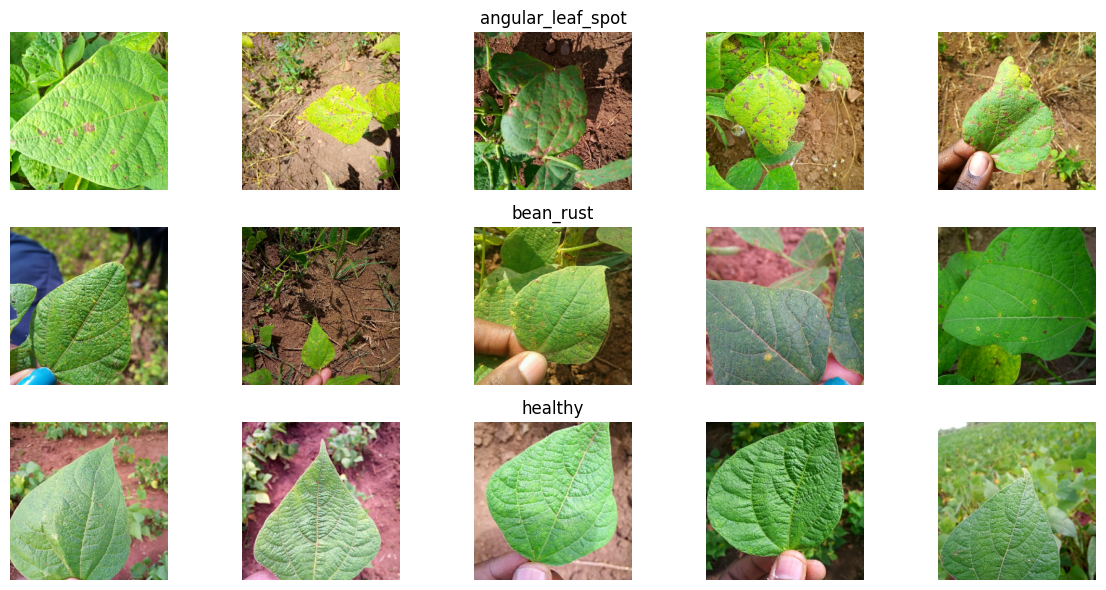

In [15]:
# Function for plotting the sample images
def plot_images(cnames: list, cimages: dict):
    fig, axes = plt.subplots(len(cnames), 5, figsize=(12, 6))

    for i, cat in enumerate(cnames):
        for j in range(5):
            if j < len(cimages[cat]):
                ax = axes[i, j]
                ax.imshow(cimages[cat][j] / 255.) # /255. to normalize RGB values of image
                # Turn off ticks for better display
                ax.axis('off')
                # Placing category name at middle image
                if j == 2:
                    ax.set_title(cat) 
    plt.tight_layout()
    # plt.savefig('../images/dataset_prev.png')
    plt.show()

# Plot the images
plot_images(class_names, class_images)

# Resnet50 (Transfer Learning)

## Creating the Model

In [3]:
# ----- Function to create resnet50 model ----- #   
def create_resnet50(input_shape):
    # ----- Input layer ----- #
    input_layer = tf.keras.Input(shape=input_shape)  

    # ----- Load ResNet50 model without the top classification layer ----- #    
    resnet50_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
    resnet50_model.trainable = False  # Freeze the ResNet50 layers
    
    # ----- Preprocess the input data ----- #
    x = tf.keras.applications.resnet50.preprocess_input(input_layer)

    # ----- Feature extraction ----- #
    features = resnet50_model(x)

    # Custom classification head
    # ----- Global Average Pooling Layer ----- #
    flat = tf.keras.layers.GlobalAveragePooling2D()(features)

    # ----- Dense layers ----- #
    dense1 = tf.keras.layers.Dense(units=32, kernel_regularizer='l2', activation='relu')(flat)
    dense1 = tf.keras.layers.Dropout(0.3)(dense1)
    
    dense2 = tf.keras.layers.Dense(units=64, kernel_regularizer='l2', activation='relu')(dense1)
    dense2 = tf.keras.layers.Dropout(0.2)(dense2)
   
    # Output layer
    outputs = tf.keras.layers.Dense(3, activation='softmax')(dense2)  

    # ----- Construct the final model with the input and output layers ----- #
    model = tf.keras.Model(input_layer, outputs)
    return model

In [4]:
resnet50 = create_resnet50(
    input_shape=(256, 256, 3),
)
resnet50.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568 

## Compiling the Model

In [5]:
resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint('../models/best_resnet50.h5', monitor='val_accuracy', save_best_only=True),
]

epochs = 30 

## Training the Model

In [6]:
# ----- Initiating training ------ #        
resnet50_history = resnet50.fit(
    train_set,
    validation_data=val_set,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/30
33/33 [==============================] - 14s 241ms/step - loss: 1.6657 - accuracy: 0.6344 - val_loss: 1.1606 - val_accuracy: 0.8797
Epoch 2/30
33/33 [==============================] - 5s 156ms/step - loss: 1.0842 - accuracy: 0.8424 - val_loss: 0.8217 - val_accuracy: 0.9549
Epoch 3/30
33/33 [==============================] - 5s 144ms/step - loss: 0.8737 - accuracy: 0.8743 - val_loss: 0.6928 - val_accuracy: 0.9474
Epoch 4/30
33/33 [==============================] - 5s 146ms/step - loss: 0.7463 - accuracy: 0.8926 - val_loss: 0.6025 - val_accuracy: 0.9474
Epoch 5/30
33/33 [==============================] - 6s 160ms/step - loss: 0.6166 - accuracy: 0.9255 - val_loss: 0.5187 - val_accuracy: 0.9699
Epoch 6/30
33/33 [==============================] - 5s 149ms/step - loss: 0.5503 - accuracy: 0.9323 - val_loss: 0.4547 - val_accuracy: 0.9624
Epoch 7/30
33/33 [==============================] - 5s 151ms/step - loss: 0.4863 - accuracy: 0.9449 - val_loss: 0.4025 - val_accuracy: 0.9699
Epoch

## Evaluating the Model

In [10]:
# Function to predict categories
def predict_cats(model, dataset) -> dict:
    prediction = {}
    # Getting the true values
    true_vals = np.concatenate([label for img, label in dataset], axis=0)
    true_vals = np.argmax(true_vals, axis=-1)
    # Add true values to the dictionary
    prediction['true'] = true_vals
    # Probability of classes
    pred_prob = model.predict(dataset)
    # Getting the predicted values
    pred_vals = np.argmax(pred_prob, axis=-1)
    # Add predicted values to the dictionary
    prediction['pred'] = pred_vals

    return prediction

# Function to plot training curves
def plot_curves(history: dict):

    plt.figure(figsize=(15, 5))

    # Plot training and validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.suptitle('Model Training performance') 
    plt.show()

# Function to show model performance evaluation
def show_eval_(model, dataset: list):
    # Dictionary of true and predicted values from the dataset
    for _set in dataset:
        prediction = predict_cats(model=model, dataset=_set)

        plt.figure(figsize=(10, 7)) 
        # Confusion matrix 
        ax = sns.heatmap(confusion_matrix(prediction['true'], prediction['pred']), annot=True, xticklabels=_set.class_names , yticklabels=_set.class_names)
        ax.set_title('Confusion Matrix')
        plt.show()

        print("\n\nClassification Report:\n")
        print(classification_report(prediction['true'], prediction['pred'], target_names=_set.class_names))

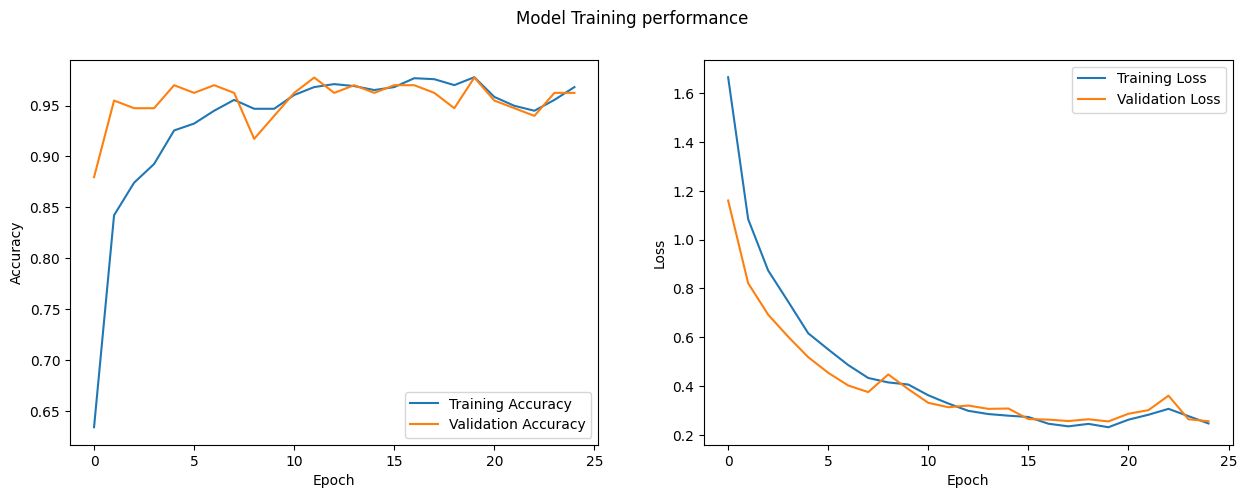

In [8]:
# ----- Show training (loss and accuracy) curves during the model training process ----- #
plot_curves(resnet50_history.history)

4/4 [==============================] - 2s 184ms/step


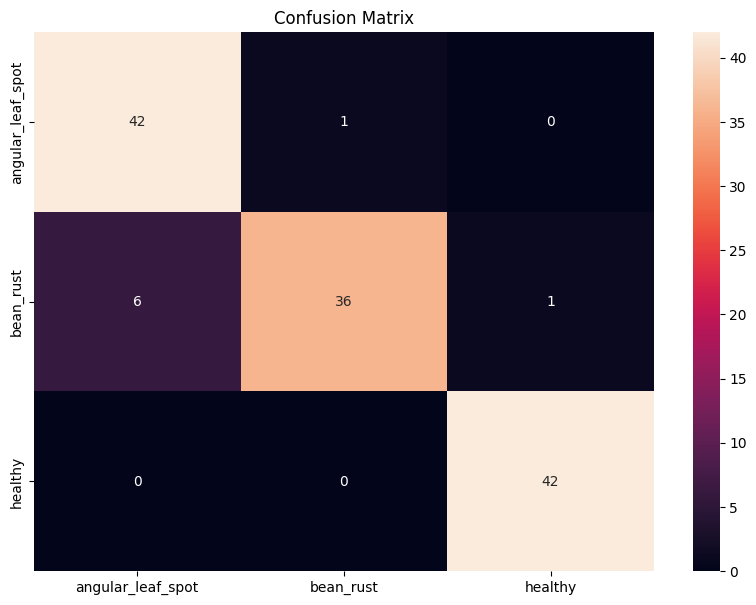



Classification Report:

                   precision    recall  f1-score   support

angular_leaf_spot       0.88      0.98      0.92        43
        bean_rust       0.97      0.84      0.90        43
          healthy       0.98      1.00      0.99        42

         accuracy                           0.94       128
        macro avg       0.94      0.94      0.94       128
     weighted avg       0.94      0.94      0.94       128

5/5 [==============================] - 1s 135ms/step


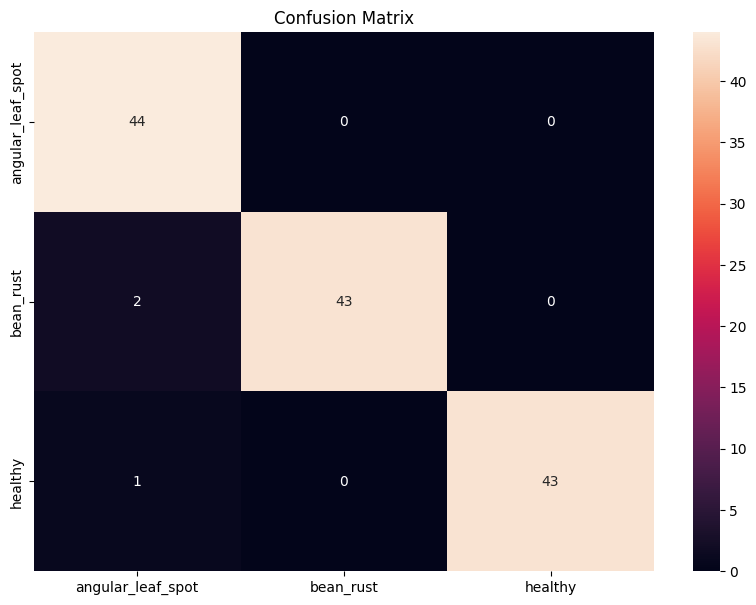



Classification Report:

                   precision    recall  f1-score   support

angular_leaf_spot       0.94      1.00      0.97        44
        bean_rust       1.00      0.96      0.98        45
          healthy       1.00      0.98      0.99        44

         accuracy                           0.98       133
        macro avg       0.98      0.98      0.98       133
     weighted avg       0.98      0.98      0.98       133



In [13]:
# Loading best model from directory
best_resnet50 = tf.keras.models.load_model('../models/best_resnet50.h5')  
# Show model evaluation
show_eval_(model=best_resnet50, dataset=[test_set, val_set])